In [11]:
import sys
import re
import os
import pandas as pd
sys.path.append("../automaterialsdata/")

from chemdataextractor_parsers import NumericalProperty, OPVPropertyParser
from chemdataextractor_parsers import OPVMaterials, OPVMaterialsParser
from chemdataextractor_parsers import sentence_preprocessing

from chemdataextractor import Document
from chemdataextractor.model import Compound,ListType, ModelType
from chemdataextractor.doc import Paragraph, Sentence

Compound.opv_materials = ListType(ModelType(OPVMaterials))
Compound.opv_property = ListType(ModelType(NumericalProperty))
Sentence.parsers.append(OPVMaterialsParser())
Paragraph.parsers.append(OPVMaterialsParser())
Sentence.parsers.append(OPVPropertyParser())
Paragraph.parsers.append(OPVPropertyParser())

In [12]:
saeki_papers_path = "/Users/hanghu/Desktop/msedatapipeline/JPCL2018-papers/_PDF"
saeki_papers = [x for x in os.listdir(saeki_papers_path) if x.endswith('pdf') ]
saeki_papers = sorted(saeki_papers, key=lambda x: int(re.match(r'[0-9]+', x)[0]))

saeki_papers[:10]

['1 PBTTT-C14.pdf',
 '2 Blouin_et_al-2007-Advanced_Materials.pdf',
 '3 PCPDTBT.pdf',
 '4 PffBT4T.pdf',
 '5 PBDTTT-CF.pdf',
 '6 PSBTBT.pdf',
 '7 PNTz4T.pdf',
 '8 PSEHTT.pdf',
 '9 PNOz4T.pdf',
 '10 P3HT.pdf']

In [13]:
def create_empty_opv_property_dataframe():
    colnames = ["Paper", "Material", "Property", "Value", "Unit"]
    return pd.DataFrame(columns=colnames)

def count_record_fields(r):
    counter = {'opv_materials': 0, 'opv_property': 0}
    for entry in r:
        entry_name = list(entry.keys())[0]
        counter[entry_name] += 1
        
    return counter['opv_materials'], counter['opv_property']

def check_record_row(row):
    if (row[2] == 'FF' and 1 < float(row[3]) < 100):
        row[3] = str(float(row[3]) / 100)
    
    if (row[2] == 'PCE' or row[2] == 'FF') and float(row[3]) > 100:
        return False
    
    return True 

In [14]:
def merge_records_to_dataframe(article_id, records):
    output_df = create_empty_opv_property_dataframe()
    colnames = list(output_df.columns)
    rows = set() 
    for r in records:
        material   = 'unknown'
        properties = []
        for entry in r:
            if 'opv_materials' in entry.keys():
                material = entry['opv_materials'][0]['name']
            else:
                property_i = entry['opv_property'][0]
                property_i['name'] = OPVPropertyParser.find_unique_name(property_i['name'])
                properties.append([property_i['name'], property_i['value'], property_i.get('unit', 'N/A')])

        for p in properties:
            p_row = [article_id, material] + p
            if check_record_row(p_row):
                rows.add(tuple(p_row))
                
                            
    # remove duplicate value with unknown materials
    duplicate_rows = set()
    for r in rows:
        if r[1] != 'unknown':
            exam_r = list(r)
            exam_r[1] = 'unknown'
            exam_r = tuple(exam_r)
            if exam_r in rows:
                duplicate_rows.add(exam_r)
    
    for dr in duplicate_rows:
        rows.remove(dr)
    
    for r in rows:
        temp_df = pd.DataFrame(data=[list(r)], columns=colnames)
        output_df = pd.concat([output_df, temp_df], ignore_index=True)

    return output_df

In [15]:
output_df = create_empty_opv_property_dataframe()

for article in saeki_papers:
    print('* parsing ', article)
    f = open(os.path.join(saeki_papers_path, article), 'rb') #Extracting pdf article from One Compound folder
    try:
        doc = Document.from_file(f) 
    except:
        continue
    para = doc.elements # Outputs list of paragaph objects
    sentence_records = []
    for p in para: # stores all sentences from paragraphs
        i = 0
        useprev  = False
        while i < len(p):
            s = sentence_preprocessing(p[i])
            if useprev: s = sentence_preprocessing(p[i-1]) + s
            r = s.records.serialize()
            nMat, nP = count_record_fields(r)
            
            if nMat > 1 or nP == 0 or (nMat == 0 and nP == 0):
                i += 1
                useprev = False
            elif (nMat == 1 and nP > 0):
                sentence_records.append(r)
                i += 1
                useprev = False
            else:
                if (not useprev):
                    useprev = True
                    continue
                sentence_records.append(r)
                i += 1
                useprev = False
            
            
    temp_df = merge_records_to_dataframe(article, sentence_records)
    output_df = pd.concat([output_df, temp_df], ignore_index=True)
    
    print(' ... obtained ', len(temp_df), " records, total number of records now is ", len(output_df))
    
output_df.to_csv("../data/CDE_PDF_Results.csv")

* parsing  1 PBTTT-C14.pdf
 ... obtained  4  records, total number of records now is  4
* parsing  2 Blouin_et_al-2007-Advanced_Materials.pdf
 ... obtained  6  records, total number of records now is  10
* parsing  3 PCPDTBT.pdf
 ... obtained  4  records, total number of records now is  14
* parsing  4 PffBT4T.pdf
 ... obtained  10  records, total number of records now is  24
* parsing  5 PBDTTT-CF.pdf
 ... obtained  11  records, total number of records now is  35
* parsing  6 PSBTBT.pdf
 ... obtained  6  records, total number of records now is  41
* parsing  7 PNTz4T.pdf
 ... obtained  17  records, total number of records now is  58
* parsing  8 PSEHTT.pdf
 ... obtained  4  records, total number of records now is  62
* parsing  9 PNOz4T.pdf
 ... obtained  20  records, total number of records now is  82
* parsing  10 P3HT.pdf
 ... obtained  23  records, total number of records now is  105
* parsing  11 PQT-12.pdf
 ... obtained  6  records, total number of records now is  111
* parsing 

 ... obtained  4  records, total number of records now is  537
* parsing  87 Hendriks_et_al-2013-Angewandte_Chemie_(International_ed._in_English).pdf
 ... obtained  1  records, total number of records now is  538
* parsing  88 ja511984q.pdf
 ... obtained  8  records, total number of records now is  546
* parsing  89 ja2089662.pdf
 ... obtained  1  records, total number of records now is  547
* parsing  90Dou_et_al-2013-Advanced_Materials.pdf
 ... obtained  10  records, total number of records now is  557
* parsing  91 c3cc47868h.pdf
 ... obtained  10  records, total number of records now is  567
* parsing  92 c1ee01213d.pdf
 ... obtained  5  records, total number of records now is  572
* parsing  93 ja4101003.pdf
 ... obtained  6  records, total number of records now is  578
* parsing  94 c4ta04118f.pdf
 ... obtained  0  records, total number of records now is  578
* parsing  95 pj201696a.pdf
 ... obtained  16  records, total number of records now is  594
* parsing  96 Zhou_et_al-2012-

 ... obtained  5  records, total number of records now is  1177
* parsing  167 Zhang_et_al-2015-Advanced_Materials.pdf
 ... obtained  10  records, total number of records now is  1187
* parsing  168 cm3017006.pdf
 ... obtained  13  records, total number of records now is  1200
* parsing  169 C6PY00640J.pdf
 ... obtained  4  records, total number of records now is  1204
* parsing  170 art%3A10.1007%2Fs11426-016-0349-7.pdf
 ... obtained  13  records, total number of records now is  1217
* parsing  171 C6TC02915A.pdf
 ... obtained  6  records, total number of records now is  1223
* parsing  172 Huo_et_al-2015-Advanced_Materials.pdf
 ... obtained  9  records, total number of records now is  1232
* parsing  173 Liu_et_al-2017-Advanced_Materials.pdf
 ... obtained  19  records, total number of records now is  1251
* parsing  174 1-s2.0-S1566119914003541-main.pdf
 ... obtained  9  records, total number of records now is  1260
* parsing  175 C3CP54022G.pdf
 ... obtained  1  records, total numbe

 ... obtained  4  records, total number of records now is  1697
* parsing  245 cm302861s.pdf
 ... obtained  8  records, total number of records now is  1705
* parsing  246 ma300060z.pdf
 ... obtained  5  records, total number of records now is  1710
* parsing  247 Wang_et_al-2014-Macromolecular_Chemistry_and_Physics.pdf
 ... obtained  6  records, total number of records now is  1716
* parsing  248 1-s2.0-S1566119914005345-main.pdf
 ... obtained  17  records, total number of records now is  1733
* parsing  249 c5py00305a.pdf
 ... obtained  12  records, total number of records now is  1745
* parsing  250 c3tc32087a.pdf
 ... obtained  0  records, total number of records now is  1745
* parsing  251 c4ta05445h.pdf
 ... obtained  3  records, total number of records now is  1748
* parsing  252 c4ta01479k.pdf
 ... obtained  2  records, total number of records now is  1750
* parsing  253 c5ta05096k.pdf
 ... obtained  1  records, total number of records now is  1751
* parsing  254 1-s2.0-S156611

 ... obtained  14  records, total number of records now is  2262
* parsing  325 ja311700u.pdf
 ... obtained  4  records, total number of records now is  2266
* parsing  326 ma202764v.pdf
 ... obtained  7  records, total number of records now is  2273
* parsing  327 C3EE41948G.pdf
 ... obtained  11  records, total number of records now is  2284
* parsing  328 c3ra47098a.pdf
 ... obtained  6  records, total number of records now is  2290
* parsing  329 Cheng_et_al-2012-Chemistry_-_An_Asian_Journal.pdf
 ... obtained  6  records, total number of records now is  2296
* parsing  330 Bronstein_et_al-2011-Macromolecular_Rapid_Communications.pdf
 ... obtained  2  records, total number of records now is  2298
* parsing  331 c2cc33718e.pdf
 ... obtained  6  records, total number of records now is  2304
* parsing  332 ma302390z.pdf
 ... obtained  1  records, total number of records now is  2305
* parsing  333 c2cc18189d.pdf
 ... obtained  20  records, total number of records now is  2325
* parsing

 ... obtained  8  records, total number of records now is  2847
* parsing  404 ACS Appl. Mater. Interfaces 2017, 9, 24011.pdf
 ... obtained  6  records, total number of records now is  2853
* parsing  405 ACS Appl. Mater. Interfaces 2017, 9, 24020.pdf
 ... obtained  21  records, total number of records now is  2874
* parsing  406 Adv. Energy Mater. 2016, 6, 1600148.pdf
 ... obtained  8  records, total number of records now is  2882
* parsing  407 Adv. Energy Mater. 2016, 6, 1600430.pdf
 ... obtained  10  records, total number of records now is  2892
* parsing  408 Adv. Energy Mater. 2017, 7, 1601138.pdf
 ... obtained  4  records, total number of records now is  2896
* parsing  409 Adv. Energy Mater. 2017, 1702166.pdf
 ... obtained  13  records, total number of records now is  2909
* parsing  410 Adv. Funct. Mater. 2016, 26, 226.pdf
 ... obtained  3  records, total number of records now is  2912
* parsing  411 Adv. Funct. Mater. 2017, 27, 1701491.pdf
 ... obtained  6  records, total num

 ... obtained  14  records, total number of records now is  3429
* parsing  475 Organic Electronics 46 (2017) 192.pdf
 ... obtained  9  records, total number of records now is  3438
* parsing  476 Phys. Chem. Chem. Phys., 2016, 18, 8389.pdf
 ... obtained  12  records, total number of records now is  3450
* parsing  477 Polym Int 2017; 66, 1206.pdf
 ... obtained  3  records, total number of records now is  3453
* parsing  478 Polym. Chem., 2016, 7, 164.pdf
 ... obtained  5  records, total number of records now is  3458
* parsing  479 Polym. Chem., 2016, 7, 2329.pdf
 ... obtained  9  records, total number of records now is  3467
* parsing  480 Polym. Chem., 2017, 8, 2334.pdf
 ... obtained  7  records, total number of records now is  3474
* parsing  481 Polym. Chem., 2017, 8, 2979.pdf
 ... obtained  11  records, total number of records now is  3485
* parsing  482 Polym. Chem., 2017, 8, 3622.pdf
 ... obtained  6  records, total number of records now is  3491
* parsing  483 Polym. Chem., 20

In [16]:
len(output_df[output_df['Material'] != 'unknown'])

2562

In [17]:
output_df.head(5)

,Paper,Material,Property,Value,Unit
0,1 PBTTT-C14.pdf,unknown,FF,0.48,N/A
1,1 PBTTT-C14.pdf,pBTTT,PCE,2.3,%
2,1 PBTTT-C14.pdf,pBTTT:PC-71-BM,JSC,9.37,mA/cm2
3,1 PBTTT-C14.pdf,pBTTT:PC-71-BM,VOC,0.525,V
4,2 Blouin_et_al-2007-Advanced_Materials.pdf,PCBM,PCE,3.6,%


# Accuracy of CDE

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from property_comparison import OPV_PROPERTIES, EXAM_TYPE, compare_properties

In [19]:
data_path = '../data/CDE_PDF_Results.csv'
data = pd.read_csv(data_path, encoding="UTF-8")

saeki_path = '../../Saekis_manual_dataset.csv'
saeki_cols = ['ID No.','Nickname', 'Ref. No', 'PCE_max', 'PCE_ave', 'Voc', 'Jsc', 'FF']
saeki = pd.read_csv(saeki_path, encoding="UTF-8", usecols=saeki_cols)

In [20]:
#Clean NAs and non-numbers from property values

data[["Value"]] = data[["Value"]].apply(pd.to_numeric)
data.dropna(subset = ["Value"], inplace=True)

In [21]:
print(len(data['Paper'].unique()), len(saeki['Ref. No'].unique()))
data['Paper'].unique()[:5], saeki['Ref. No'].unique()[:5]

476 503


(array(['1 PBTTT-C14.pdf', '2 Blouin_et_al-2007-Advanced_Materials.pdf',
        '3 PCPDTBT.pdf', '4 PffBT4T.pdf', '5 PBDTTT-CF.pdf'], dtype=object),
 array(['S1', 'S2', 'S3', 'S4', 'S5'], dtype=object))

In [22]:
colnames  = ['Ref. No']

for p in OPV_PROPERTIES:
    for eT in EXAM_TYPE:
        colnames.append('_'.join([p,eT]))

comp_result = pd.DataFrame(columns=colnames)

In [23]:
saeki_cols = ['PCE_max', 'Voc', 'Jsc', 'FF']
errors = [0.1, 0.1, 0.1, 0.01]
saeki_papers = set([int(x[1:]) for x in saeki['Ref. No'].unique()])

for paper in data['Paper'].unique():
    print("Compare Results from ", paper)
    paper_id = int(re.match(r'[0-9]+', paper)[0])
    tmp_result = [paper_id]
    
    saeki_papers.remove(paper_id)
    
    saeki_result = saeki[saeki['Ref. No'] == 'S'+ str(paper_id)]
    saeki_compounds = set(saeki_result['Nickname'])
    
    cdr_result = data[data['Paper'] == paper]
    cdr_compounds = set(cdr_result['Material'])
    
    for p, sp, e in zip(OPV_PROPERTIES, saeki_cols, errors):
        
        cdr_records   = list(cdr_result[cdr_result['Property'] == p][['Material', 'Value']].to_records(index=False))
        saeki_records = list(saeki_result[['Nickname', sp]].to_records(index=False))
        
        results = compare_properties(cdr_records, saeki_records, e)
        
        tmp_result += results

    temp_df = pd.DataFrame(data=[tmp_result], columns=colnames)
    comp_result = pd.concat([comp_result, temp_df], ignore_index=True)

for paper in saeki_papers:
    tmp_result = [paper]
    saeki_result = saeki[saeki['Ref. No'] == 'S'+ str(paper_id)]
    for p, sp, e in zip(OPV_PROPERTIES, saeki_cols, errors):
        cdr_records   = []
        saeki_records = list(saeki_result[['Nickname', sp]].to_records(index=False))
        results = compare_properties(cdr_records, saeki_records, e)
        
        tmp_result += results
    temp_df = pd.DataFrame(data=[tmp_result], columns=colnames)
    comp_result = pd.concat([comp_result, temp_df], ignore_index=True)
    

Compare Results from  1 PBTTT-C14.pdf
Compare Results from  2 Blouin_et_al-2007-Advanced_Materials.pdf
Compare Results from  3 PCPDTBT.pdf
Compare Results from  4 PffBT4T.pdf
Compare Results from  5 PBDTTT-CF.pdf
Compare Results from  6 PSBTBT.pdf
Compare Results from  7 PNTz4T.pdf
Compare Results from  8 PSEHTT.pdf
Compare Results from  9 PNOz4T.pdf
Compare Results from  10 P3HT.pdf
Compare Results from  11 PQT-12.pdf
Compare Results from  12 PTB7-Th.pdf
Compare Results from  13 PTB7.pdf
Compare Results from  14 c4ee01529k.pdf
Compare Results from  15 P1.pdf
Compare Results from  16 Leclerc_et_al-2006-Advanced_Functional_Materials.pdf
Compare Results from  17 nphoton.2009.69.pdf
Compare Results from  18 ja0771989.pdf
Compare Results from  19 Gendron_et_al-2010-Macromolecular_Rapid_Communications.pdf
Compare Results from  20 ma100039q.pdf
Compare Results from  21 Yi_et_al-2008-Macromolecular_Rapid_Communications.pdf
Compare Results from  22 ja907506r.pdf
Compare Results from  24 1%2E35

/Users/hanghu/Desktop/msedatapipeline/AutoMaterialsData-clean/notebooks/../automaterialsdata/property_comparison.py:59: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  idx = saeki_result.index((c,r))


 31 ja808373p.pdf
Compare Results from  32 ja9064975.pdf
Compare Results from  33 c2jm34629j.pdf
Compare Results from  34 c0cc00098a.pdf
Compare Results from  35 ma101878w.pdf
Compare Results from  36 ja200314m.pdf
Compare Results from  37 ma800820r.pdf
Compare Results from  38 Subbiah_et_al-2015-Advanced_Materials.pdf
Compare Results from  39 ja101888b.pdf
Compare Results from  40 ma301900h.pdf
Compare Results from  41 acs.macromol.5b00829.pdf
Compare Results from  42 Wu_et_al-2013-Advanced_materials_(Deerfield_Beach,_Fla.).pdf
Compare Results from  43 Ye_et_al-2012-Advanced_Materials.pdf
Compare Results from  44 Huang_et_al-2013-Advanced_Energy_Materials (1).pdf
Compare Results from  46 c3py01519j.pdf
Compare Results from  47 acs%2Emacromol%2E5b00251.pdf
Compare Results from  49 c5py00071h.pdf
Compare Results from  50 ja103275u.pdf
Compare Results from  51 Yuan_et_al-2013-Advanced_Functional_Materials.pdf
Compare Results from  52 art%3A10.1007%2Fs40843-015-0036-3.pdf
Compare Results 

Compare Results from  231 ma402245t.pdf
Compare Results from  232 ma300589k.pdf
Compare Results from  233 ma400257q.pdf
Compare Results from  234 C2PY20674A.pdf
Compare Results from  235 Xu_et_al-2014-Advanced_Functional_Materials.pdf
Compare Results from  237 Yuan_et_al-2014-Advanced_Materials.pdf
Compare Results from  238 c5py00893j.pdf
Compare Results from  239 ma202578y.pdf
Compare Results from  240 Huo_et_al-2015-Advanced_Materials.pdf
Compare Results from  241 Fu_et_al-2013-Journal_of_Polymer_Science_Part_A-_Polymer_Chemistry.pdf
Compare Results from  242 cm401527b.pdf
Compare Results from  244 c3py00391d.pdf
Compare Results from  245 cm302861s.pdf
Compare Results from  246 ma300060z.pdf
Compare Results from  247 Wang_et_al-2014-Macromolecular_Chemistry_and_Physics.pdf
Compare Results from  248 1-s2.0-S1566119914005345-main.pdf
Compare Results from  249 c5py00305a.pdf
Compare Results from  251 c4ta05445h.pdf
Compare Results from  252 c4ta01479k.pdf
Compare Results from  253 c5ta0

Compare Results from  425 J Mater Sci. Mater Electron (2016) 27, 9920.pdf
Compare Results from  426 J. Mater. Chem. A, 2016, 4, 1708.pdf
Compare Results from  427 J. Mater. Chem. A, 2016, 4, 3477.pdf
Compare Results from  428 J. Mater. Chem. A, 2016, 4, 7372.pdf
Compare Results from  429 J. Mater. Chem. A, 2016, 4, 8097.pdf
Compare Results from  430 J. Mater. Chem. A, 2016, 4, 8291.pdf
Compare Results from  431 J. Mater. Chem. A, 2016, 4, 10135.pdf
Compare Results from  432 J. Mater. Chem. A, 2016, 4, 13265.pdf
Compare Results from  433 J. Mater. Chem. A, 2016, 4, 18598.pdf
Compare Results from  434 J. Mater. Chem. A, 2017, 5, 712.pdf
Compare Results from  435 J. Mater. Chem. A, 2017, 5, 5106.pdf
Compare Results from  436 J. Mater. Chem. A, 2017, 5, 7300.pdf
Compare Results from  437 J. Mater. Chem. A, 2017, 5, 20473.pdf
Compare Results from  438 J. Mater. Chem. C, 2016, 4, 2606.pdf
Compare Results from  439 J. Mater. Chem. C, 2016, 4, 6160.pdf
Compare Results from  440 J. Mater. Chem.

In [30]:
sum_results = comp_result.sum()
sum_df = pd.DataFrame(data=[], columns=['Property', 'Exam_type', 'Count'])

for p in OPV_PROPERTIES:
    for eT in EXAM_TYPE:
        col = '_'.join([p,eT])
        tmp_result = [p, eT, sum_results[col]]
        temp_df = pd.DataFrame(data=[tmp_result], columns=['Property', 'Exam_type', 'Count'])
        sum_df = pd.concat([sum_df, temp_df], ignore_index=True)

sum_df

,Property,Exam_type,Count
0,PCE,value_only_TP,537
1,PCE,value_only_FN,951
2,PCE,value_only_Miss,613
3,PCE,TP,105
4,PCE,FP,65
5,PCE,FN,1318
6,PCE,Miss,1045
7,VOC,value_only_TP,485
8,VOC,value_only_FN,226
9,VOC,value_only_Miss,665


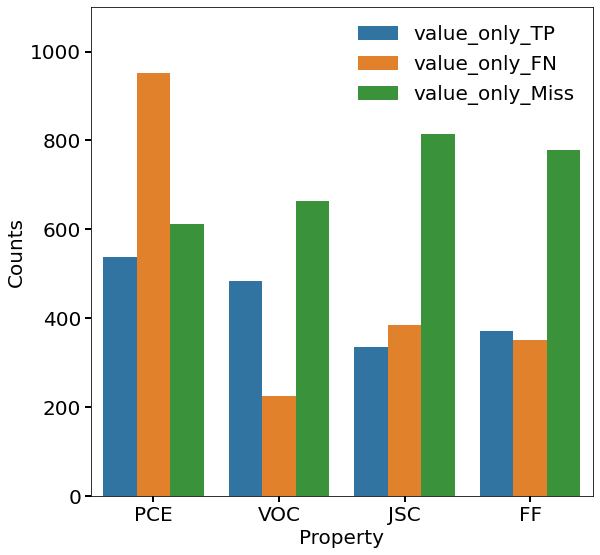

In [27]:
fig,ax = plt.subplots(figsize=(9,9))

sns.barplot(x="Property", y="Count", hue="Exam_type", data=sum_df, ax=ax)

ax.set_xlabel('Property', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)
ax.tick_params(direction='out', length=6, width=2, labelsize=20)
ax.legend(frameon=False, fontsize=20) 
ax.set_ylim([0, 1100])


fig.savefig('./chemdataextractor_result_1.png', bbox_inches='tight') 

<AxesSubplot:xlabel='Property', ylabel='Count'>

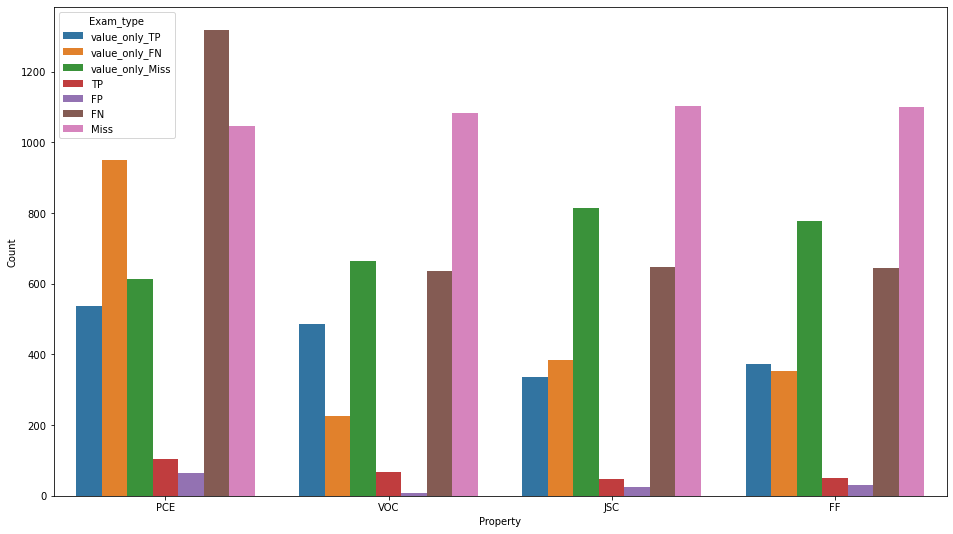

In [31]:
fig,ax = plt.subplots(figsize=(16,9))
sns.barplot(x="Property", y="Count", hue="Exam_type", data=sum_df, ax=ax)

In [19]:
for paper in data['Paper'].unique()[:10]:
    print("Compare Results from ", paper)
    paper_id = int(re.match(r'[0-9]+', paper)[0])
    tmp_result = [paper_id]
    
    #saeki_papers.remove(paper_id)
    
    saeki_result = saeki[saeki['Ref. No'] == 'S'+ str(paper_id)]
    saeki_compounds = set(saeki_result['Nickname'])
    
    cdr_result = data[data['Paper'] == paper]
    cdr_compounds = set(cdr_result['Material'])
    
    for p, sp, e in zip(OPV_PROPERTIES, saeki_cols, errors):
        
        cdr_records   = list(cdr_result[cdr_result['Property'] == p][['Material', 'Value']].to_records(index=False))
        saeki_records = list(saeki_result[['Nickname', sp]].to_records(index=False))
        print(p)
        print("CDE", cdr_records)
        print("Saeki", saeki_records)
        results = compare_properties(cdr_records, saeki_records, e)
        tmp_result += results

    temp_df = pd.DataFrame(data=[tmp_result], columns=colnames)
    comp_result = pd.concat([comp_result, temp_df], ignore_index=True)

Compare Results from  1 PBTTT-C14.pdf
PCE
CDE [('unknown', 2.3), ('pBTTT', 2.3)]
Saeki [('PBTTT-C14', 2.34)]
VOC
CDE [('pBTTT:PC-71-BM', 0.525), ('unknown', 0.525)]
Saeki [('PBTTT-C14', 0.53)]
JSC
CDE [('pBTTT:PC-71-BM', 9.37), ('unknown', 9.37)]
Saeki [('PBTTT-C14', 9.37)]
FF
CDE [('unknown', 0.48)]
Saeki [('PBTTT-C14', 0.48)]
Compare Results from  2 Blouin_et_al-2007-Advanced_Materials.pdf
PCE
CDE [('PCBM', 3.6), ('unknown', 3.6), ('unknown', 0.6), ('unknown', 3.), ('unknown', 0.8)]
Saeki [('PCDTBT', 3.6)]
VOC
CDE [('unknown', 0.89), ('unknown', 0.9)]
Saeki [('PCDTBT', 0.89)]
JSC
CDE []
Saeki [('PCDTBT', 6.92)]
FF
CDE []
Saeki [('PCDTBT', 0.63)]
Compare Results from  3 PCPDTBT.pdf
PCE
CDE [('unknown', 5.1)]
Saeki [('PCPDTBT', 5.12)]
VOC
CDE [('unknown', 0.61)]
Saeki [('PCPDTBT', 0.61)]
JSC
CDE [('unknown', 15.7)]
Saeki [('PCPDTBT', 15.73)]
FF
CDE [('unknown', 0.53)]
Saeki [('PCPDTBT', 0.53)]
Compare Results from  4 PffBT4T.pdf
PCE
CDE [('unknown', 10.36), ('unknown', 49.), ('E135–E13